In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
import psutil
from concurrent.futures import ThreadPoolExecutor
import random
import time
import dask.array as da
import cupy as cp

# Getting data ready

In [ ]:
df_products = pd.read_csv('olist_products_dataset.csv')
df_product_category_translation = pd.read_csv('product_category_name_translation.csv')
# Merge df_products with df_product_category_translation
products_merged = pd.merge(df_products, df_product_category_translation, on='product_category_name')

df_orders = pd.read_csv('olist_orders_dataset.csv')
df_order_items = pd.read_csv('olist_order_items_dataset.csv')
# Merge df_orders with df_order_items
order_items_merged = pd.merge(df_orders, df_order_items, on='order_id')

df_customers = pd.read_csv('olist_customers_dataset.csv')
# Merge the resulting DataFrame with df_customers
order_customer_merged = pd.merge(order_items_merged, df_customers, on='customer_id')

# Merge the resulting DataFrame with products_merged
order_product_merged = pd.merge(order_customer_merged, products_merged, on='product_id')

df_sellers = pd.read_csv('olist_sellers_dataset.csv')
# Merge the resulting DataFrame with df_sellers
order_seller_merged = pd.merge(order_product_merged, df_sellers, on='seller_id')

df_order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
# Merge the resulting DataFrame with df_order_reviews
order_review_merged = pd.merge(order_seller_merged, df_order_reviews, on='order_id')

df_order_payments = pd.read_csv('olist_order_payments_dataset.csv')
# Merge the resulting DataFrame with df_order_payments
analysis_df = pd.merge(order_review_merged, df_order_payments, on='order_id')

# Choose a specific product category to analyze
product_category = "health_beauty"
filtered_df = analysis_df[analysis_df['product_category_name_english'] == product_category]

# Group the data by seller state or city, and calculate the metrics of interest
grouped_data = filtered_df.groupby('seller_state')

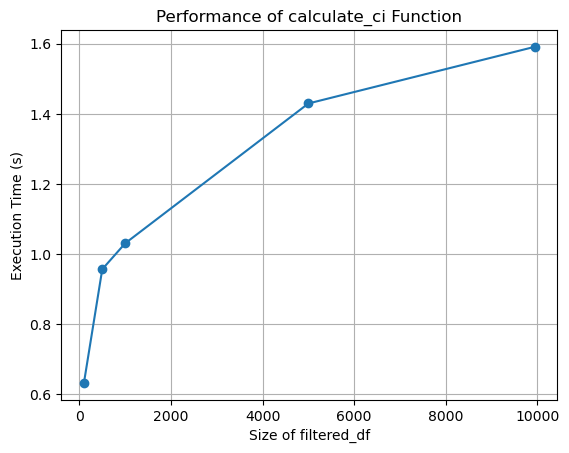

In [ ]:
# Your bootstrap_CI function here
def bootstrap_CI(data, func, n_bootstraps=1000, ci=95, axis=0):
    """
    Generate a confidence interval for a given statistic using bootstrapping.

    Parameters:
    data (numpy.ndarray or pandas.DataFrame): The data to calculate the statistic from.
    func (callable): The function used to calculate the statistic.
    n_bootstraps (int): The number of bootstrap samples to generate.
    ci (float): The confidence interval percentage (e.g., 95 for a 95% CI).
    axis (int): The axis along which to apply the statistic function (0 for columns, 1 for rows).

    Returns:
    tuple: The lower and upper bounds of the confidence interval.
    """

    bootstrapped_statistics = []
    for _ in range(n_bootstraps):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_statistic = func(bootstrap_sample, axis=axis)
        bootstrapped_statistics.append(bootstrapped_statistic)

    lower_bound = np.percentile(bootstrapped_statistics, (100 - ci) / 2)
    upper_bound = np.percentile(bootstrapped_statistics, 100 - (100 - ci) / 2)

    return lower_bound, upper_bound

# Your calculate_ci function here
def calculate_ci(group):
    return pd.Series({
        'price_ci_lower': bootstrap_CI(group['price'], np.mean, n_bootstraps=1000, ci=95)[0],
        'price_ci_upper': bootstrap_CI(group['price'], np.mean, n_bootstraps=1000, ci=95)[1],
        'review_score_ci_lower': bootstrap_CI(group['review_score'], np.mean, n_bootstraps=1000, ci=95)[0],
        'review_score_ci_upper': bootstrap_CI(group['review_score'], np.mean, n_bootstraps=1000, ci=95)[1]
    })

# Use your actual filtered_df DataFrame

def measure_performance(data_sizes):
    """
    Measure the performance of the calculate_ci function for different input data sizes.

    Parameters:
    data_sizes (list): A list of data sizes to test.

    Returns:
    list: A list of execution times for each data size.
    """
    times = []
    for data_size in data_sizes:
        subset_df = filtered_df.sample(n=data_size, replace=False, random_state=42)
        grouped_data = subset_df.groupby('seller_state')

        start_time = timeit.default_timer()
        ci_df = grouped_data.apply(calculate_ci)
        end_time = timeit.default_timer()
        times.append(end_time - start_time)

    return times

data_sizes = [100, 500, 1000, 5000, 9944]
times = measure_performance(data_sizes)

plt.plot(data_sizes, times, marker='o')
plt.xlabel('Size of filtered_df')
plt.ylabel('Execution Time (s)')
plt.title('Performance of calculate_ci Function')
plt.grid(True)
plt.show()

In [ ]:
def measure_performance(func, data_sizes):
    """
    Measure the performance of the calculate_ci function for different input data sizes.

    Parameters:
    data_sizes (list): A list of data sizes to test.

    Returns:
    list: A list of execution times for each data size.
    """
    times = []
    throughputs = []
    for data_size in data_sizes:
        subset_df = filtered_df.sample(n=data_size, replace=False, random_state=42)
        grouped_data = subset_df.groupby('seller_state')

        start_time = timeit.default_timer()
        ci_df = grouped_data.apply(func)
        end_time = timeit.default_timer()

        elapsed_time = end_time - start_time
        throughput = data_size / elapsed_time

        times.append(elapsed_time)
        throughputs.append(throughput)

    return times, throughputs

In [ ]:
data_sizes = [100, 500, 1000, 1500, 3000, 5000, 7000, 9944]
times, thoroughputs = measure_performance(calculate_ci, data_sizes)

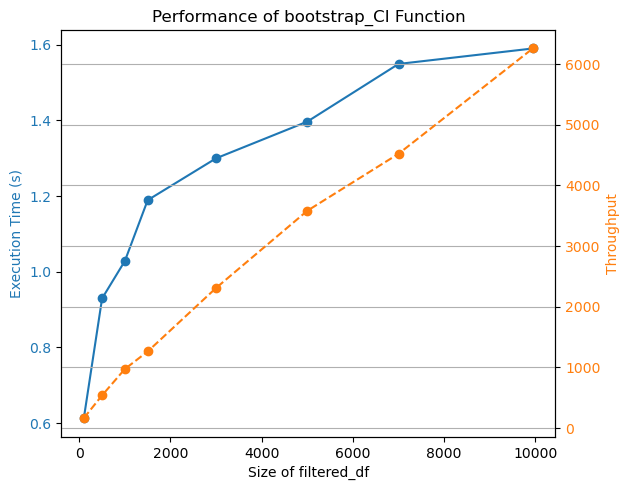

In [ ]:
def plot_performance(data_sizes, times, throughputs, y1label, y2label):
    """
    Plot the performance of the calculate_ci function for different input data sizes.

    Parameters:
    data_sizes (list): A list of data sizes tested.
    times (list): A list of execution times for each data size.
    throughputs (list): A list of throughputs for each data size.

    Returns:
    None
    """
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Size of filtered_df')
    ax1.set_ylabel(y1label, color=color)
    ax1.plot(data_sizes, times, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:orange'
    ax2.set_ylabel(y2label, color=color)  # we already handled the x-label with ax1
    ax2.plot(data_sizes, throughputs, marker='o', linestyle='--', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Performance of bootstrap_CI Function')
    plt.grid(True)
    plt.show()
plot_performance(data_sizes, times, thoroughputs,'Execution Time (s)', 'Throughput')

In [ ]:
def monitor_cpu_io_memory(duration, interval):
    cpu_percentages = []
    io_counters = []
    memory_usages = []

    end_time = time.time() + duration
    while time.time() < end_time:
        cpu_percentages.append(psutil.cpu_percent(interval=interval))
        io_counters.append(psutil.disk_io_counters())
        memory_usages.append(psutil.virtual_memory().used)
        time.sleep(interval)

    return cpu_percentages, io_counters, memory_usages

# Monitor CPU, I/O activity, and memory usage for 10 seconds with 1-second intervals
cpu_percentages, io_counters, memory_usages = monitor_cpu_io_memory(duration=1, interval=.1)

# Capture memory usage before running your_function()
memory_before = psutil.virtual_memory().used

# Run your function
grouped_data.apply(calculate_ci)

# Capture memory usage after running your_function()
memory_after = psutil.virtual_memory().used

# Calculate function's memory usage
function_memory_usage = memory_after - memory_before

# Analyze CPU usage
avg_cpu_usage = sum(cpu_percentages) / len(cpu_percentages)
print(f"Average CPU usage: {avg_cpu_usage}%")

# Analyze I/O activity
read_bytes = [c.read_bytes for c in io_counters]
write_bytes = [c.write_bytes for c in io_counters]
print(f"Total read bytes: {sum(read_bytes)}")
print(f"Total write bytes: {sum(write_bytes)}")

# Analyze memory usage
avg_memory_usage = sum(memory_usages) / len(memory_usages) - memory_before
print(f"Average memory usage during function execution: {avg_memory_usage / (1024 * 1024):.2f} MB")
print(f"Function memory usage: {function_memory_usage / (1024 * 1024):.2f} MB")

Average CPU usage: 3.0%
Total read bytes: 182899024384
Total write bytes: 705607109632
Average memory usage during function execution: 48.05 MB
Function memory usage: -3.21 MB


In [ ]:
def bootstrap_CI_optimized(data, func, n_bootstraps=1000, ci=95, axis=0):
    data = np.asarray(data)
    idx = np.random.randint(0, len(data), size=(n_bootstraps, len(data)))
    bootstrap_samples = data[idx]

    bootstrapped_statistics = func(bootstrap_samples, axis=axis)

    lower_bound = np.percentile(bootstrapped_statistics, (100 - ci) / 2)
    upper_bound = np.percentile(bootstrapped_statistics, 100 - (100 - ci) / 2)

    return lower_bound, upper_bound

In [ ]:
def calculate_ci_optimized(group):
    return pd.Series({
        'price_ci_lower': bootstrap_CI_optimized(group['price'], np.mean, n_bootstraps=1000, ci=95)[0],
        'price_ci_upper': bootstrap_CI_optimized(group['price'], np.mean, n_bootstraps=1000, ci=95)[1],
        'review_score_ci_lower': bootstrap_CI_optimized(group['review_score'], np.mean, n_bootstraps=1000, ci=95)[0],
        'review_score_ci_upper': bootstrap_CI_optimized(group['review_score'], np.mean, n_bootstraps=1000, ci=95)[1]
    })

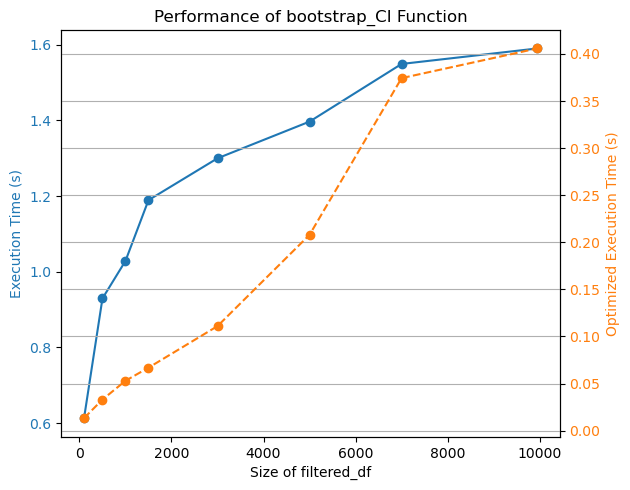

In [ ]:
times_opt, thoroughputs_opt = measure_performance(calculate_ci_optimized, data_sizes)
plot_performance(data_sizes, times, times_opt, 'Execution Time (s)', 'Optimized Execution Time (s)')

In [ ]:
def bootstrap_CI_parallelized(data, func, n_bootstraps=1000, ci=95, axis=0):
    def single_bootstrap(idx):
        bootstrap_sample = data[idx]
        return func(bootstrap_sample, axis=axis)

    data = np.asarray(data)
    idx = np.random.randint(0, len(data), size=(n_bootstraps, len(data)))

    # Set the number of threads you want to use for parallelization
    num_threads = 4

    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        bootstrapped_statistics = list(executor.map(single_bootstrap, idx))

    lower_bound = np.percentile(bootstrapped_statistics, (100 - ci) / 2)
    upper_bound = np.percentile(bootstrapped_statistics, 100 - (100 - ci) / 2)

    return lower_bound, upper_bound

def calculate_ci_parallelized(group):
    return pd.Series({
        'price_ci_lower': bootstrap_CI_parallelized(group['price'], np.mean, n_bootstraps=1000, ci=95)[0],
        'price_ci_upper': bootstrap_CI_parallelized(group['price'], np.mean, n_bootstraps=1000, ci=95)[1],
        'review_score_ci_lower': bootstrap_CI_parallelized(group['review_score'], np.mean, n_bootstraps=1000, ci=95)[0],
        'review_score_ci_upper': bootstrap_CI_parallelized(group['review_score'], np.mean, n_bootstraps=1000, ci=95)[1]
    })

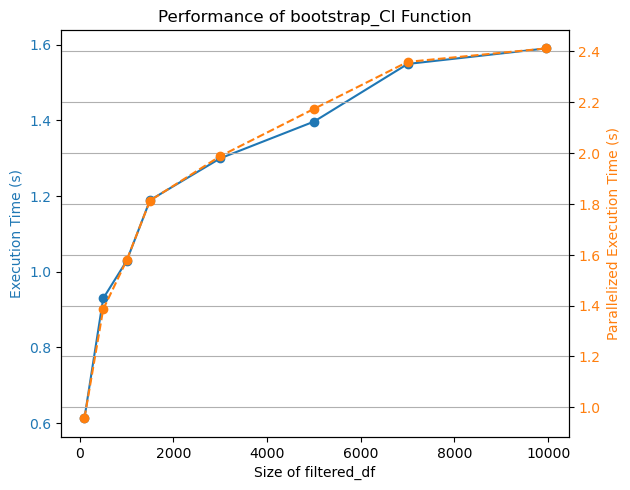

In [ ]:
times_par, thoroughputs_par = measure_performance(calculate_ci_parallelized, data_sizes)
plot_performance(data_sizes, times, times_par, 'Execution Time (s)', 'Parallelized Execution Time (s)')

In [ ]:
def bootstrap_CI_cuda(data, func, n_bootstraps=1000, ci=95, axis=0):
    data = cp.asarray(data)
    idx = cp.random.randint(0, len(data), size=(n_bootstraps, len(data)))
    bootstrap_samples = data[idx]

    bootstrapped_statistics = func(bootstrap_samples, axis=axis)

    lower_bound = cp.percentile(bootstrapped_statistics, (100 - ci) / 2)
    upper_bound = cp.percentile(bootstrapped_statistics, 100 - (100 - ci) / 2)

    return cp.asnumpy(lower_bound), cp.asnumpy(upper_bound)

def calculate_ci_cuda(group):
    return pd.Series({
        'price_ci_lower': bootstrap_CI_cuda(group['price'], np.mean, n_bootstraps=1000, ci=95)[0],
        'price_ci_upper': bootstrap_CI_cuda(group['price'], np.mean, n_bootstraps=1000, ci=95)[1],
        'review_score_ci_lower': bootstrap_CI_cuda(group['review_score'], np.mean, n_bootstraps=1000, ci=95)[0],
        'review_score_ci_upper': bootstrap_CI_cuda(group['review_score'], np.mean, n_bootstraps=1000, ci=95)[1]
    })

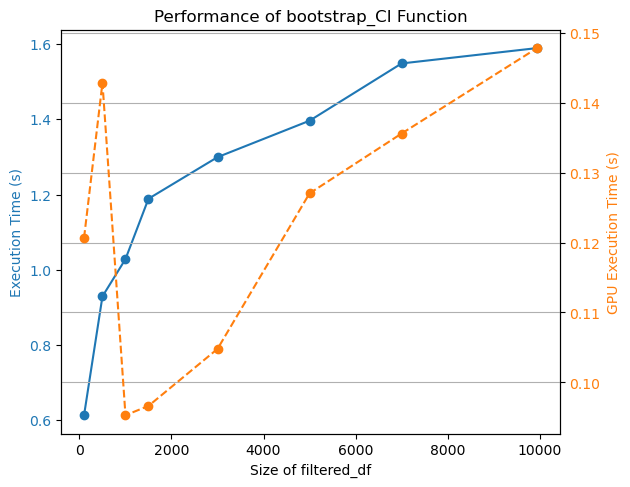

In [ ]:
times_par, thoroughputs_par = measure_performance(calculate_ci_cuda, data_sizes)
plot_performance(data_sizes, times, times_par, 'Execution Time (s)', 'GPU Execution Time (s)')